# 0. 사전 데이터 구축 및 활용 패키지 정리

In [1]:
#!/usr/bin/python
# -*- coding: UTF-8 -*-

import os
os.chdir(r"C:\Users\user\Desktop")

import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_column',100)
pd.set_option('display.max_row',500)
from pandas import DataFrame
from pandas import concat

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False
import seaborn as sns
from operator import itemgetter

import re
import requests
from bs4 import BeautifulSoup
import time

import math
from tqdm import tqdm
from collections import Counter
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

In [2]:
#현재 데이터에서 발생하는 type error를 해결하기 위한 함수 생성해둠

def coerce_df_columns_to_numeric(df, column_list):
    df[column_list] = df[column_list].apply(pd.to_numeric, errors='coerce')

#크롤링 용 함수 생성

def get_html(url):
   _html = ""
   resp = requests.get(url)
   if resp.status_code == 200:
      _html = resp.text
   return _html

#크롤링 문제 발생시 사용 함수
def is_int(x):
    if int(x)==x:
        return True
    else:
        return False

## 1-5. 목적 변수 만들기

단타, 4사구, 타율~OPS 만들기

In [13]:
# real_total=pd.read_csv("real_total.csv")

real_total2 = real_total.loc[ (real_total['tp']!="?") & (real_total['tp']!="투수") ].reset_index(drop=True)

real_total2['1B']=real_total2['H']-real_total2['2B']-real_total2['3B']-real_total2['HR']
real_total2['FBP']=real_total2['BB']+real_total2['HBP']

real_total2['avg']=round(real_total2['H']/real_total2['AB'],3)
real_total2['OBP']=round( (real_total2['H']+real_total2['FBP'])/(real_total2['AB']+real_total2['FBP']+real_total2['fly']) ,3)
real_total2['SLG']=round( real_total2['TB']/real_total2['AB'],3)
real_total2['OPS']=real_total2['SLG']+real_total2['OBP']

목적변수 생성

In [14]:
rsbd_part1=real_total2[['batter_name','year','AB','OPS']] #regular 자료에 합치는데 필요한 변수들만 추출

rsbd_part1=rsbd_part1.rename({'AB':'YAB'},axis='columns') #regular 자료와 중복 방지 위해서 이름 변경
rsbd_part1=rsbd_part1.rename({'year':'p_year'},axis='columns')
rsbd_part1=rsbd_part1.rename({'OPS':'YOPS'},axis='columns') #regular 자료와 중복 방지 위해서 이름 변경

coerce_df_columns_to_numeric(rsbd_part1,'p_year') #문자열로 인식된 p_year를 숫자로 변경

real_total2['p_year']=real_total2['year']+1 #다음 시즌과 결합을 시켜야되기 때문에 기존 연도에 1을 더해 다음 시즌 연도를 만듦

regular_y=pd.merge(real_total2,rsbd_part1,on=['batter_name','p_year'])

regular_y.shape

(1913, 37)

# 2. 데이터 정제 및 처리

## 2-1. 범주형 변수 통합

In [15]:
Counter(regular_y['cp'])

Counter({'포수': 230,
         '2루수': 213,
         '유격수': 135,
         '1루수': 212,
         '중견수': 172,
         '3루수': 243,
         '좌익수': 240,
         '우익수': 200,
         '지명타자': 268})

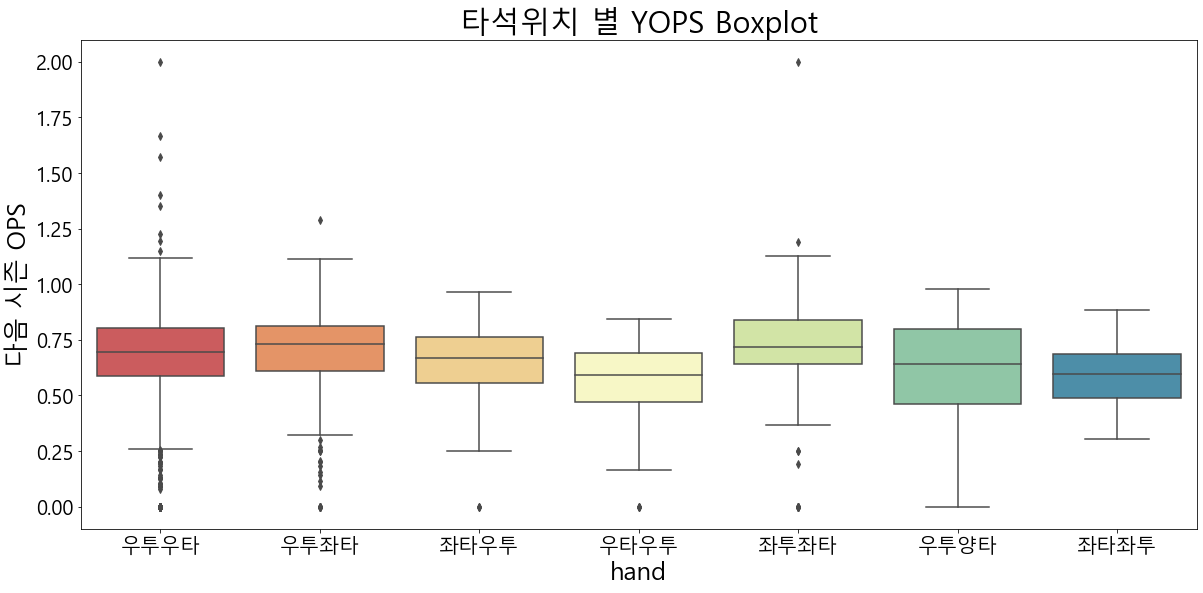

In [16]:
from matplotlib import font_manager, rc #그래프 폰트 깨질경우 방지 부분
#폰트 깨지는거 수정 부분
import platform
if platform.system()=='Windows':
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font',family=font_name)
else:
    rc('font',family='AppleGothic')

# fkd1= list(Counter(regular_y['hand2']).keys())
# fkd2= list(Counter(regular_y['hand2']).values())

plt.figure(figsize=(20,9))

sns.boxplot(x='hand2',y="YOPS", data=regular_y,palette="Spectral")
plt.title('타석위치 별 YOPS Boxplot',size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('hand',size=25)
plt.ylabel('다음 시즌 OPS',size=25);

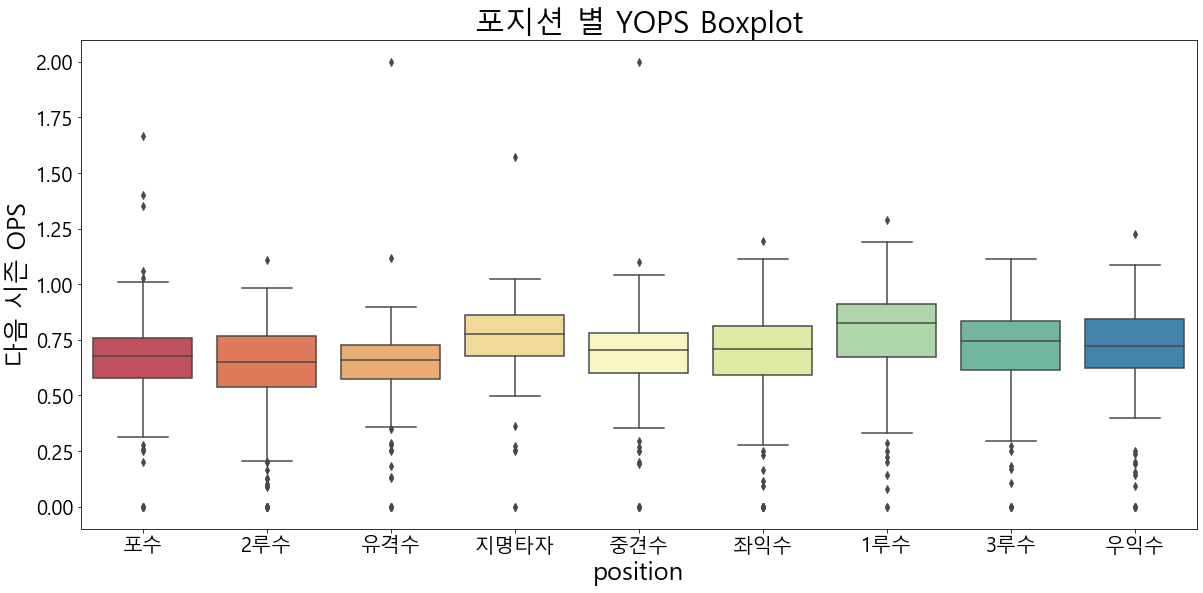

In [17]:
plt.figure(figsize=(20,9))

sns.boxplot(x='tp',y="YOPS", data=regular_y,palette="Spectral")
plt.title('포지션 별 YOPS Boxplot',size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('position',size=25)
plt.ylabel('다음 시즌 OPS',size=25);

## 2-2. 타석위치, 통합 포지션 만들기

In [18]:
#스탯티즈에서 가져온 타석 위치에 대한 통일 작업 실시 (좌타,우타,양타만 확인하고 바꾸는 방식으로 진행했다)
regular_y['hand2']=regular_y['hand2'].replace('우투우타','우타')
regular_y['hand2']=regular_y['hand2'].replace('우타우투','우타')
regular_y['hand2']=regular_y['hand2'].replace('우투양타','양타')
regular_y['hand2']=regular_y['hand2'].replace('우투좌타','좌타')

regular_y['hand2']=regular_y['hand2'].replace('좌투좌타','좌타')
regular_y['hand2']=regular_y['hand2'].replace('좌타좌투','좌타')
regular_y['hand2']=regular_y['hand2'].replace('좌타우투','좌타')

regular_y['hand2'].unique()

array(['우타', '좌타', '양타'], dtype=object)

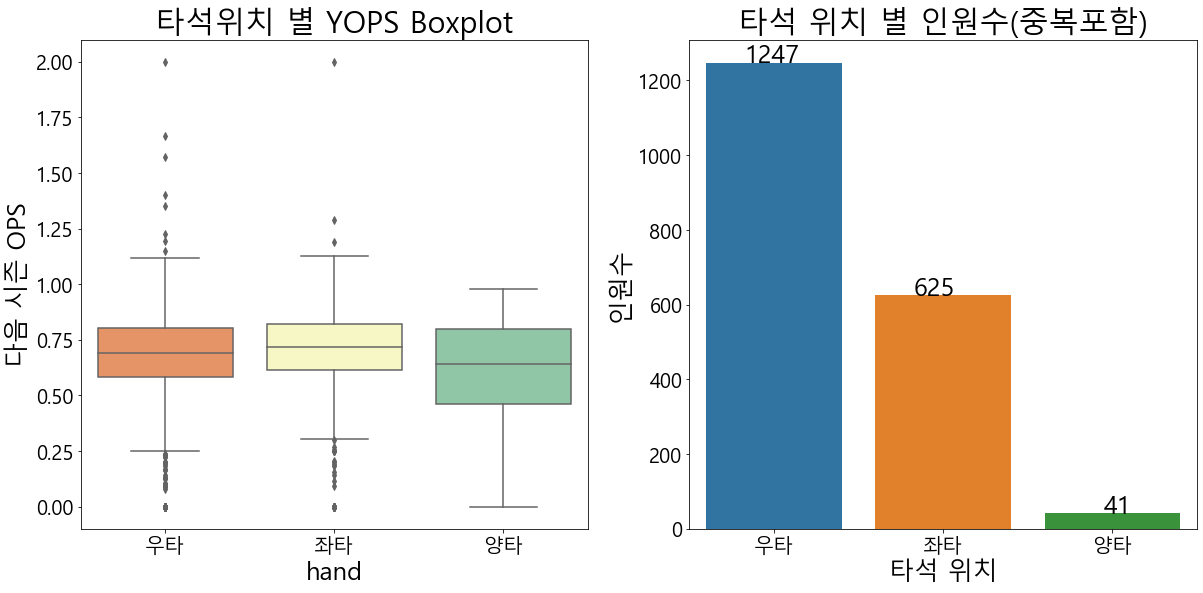

In [19]:
plt.figure(figsize=(20,9))

plt.subplot(121)
sns.boxplot(x='hand2',y="YOPS", data=regular_y,palette="Spectral")
plt.title('타석위치 별 YOPS Boxplot',size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('hand',size=25)
plt.ylabel('다음 시즌 OPS',size=25)

fkd1= list(Counter(regular_y['hand2']).keys())
fkd2= list(Counter(regular_y['hand2']).values())

plt.subplot(122)
sns.barplot(x=fkd1,y=fkd2)
plt.title('타석 위치 별 인원수(중복포함)',size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('타석 위치',size=25)
plt.ylabel('인원수',size=25)
for x,y in zip(range(0,len(fkd1)),fkd2):
    if len(str(y))==2:
        plt.text(x-0.05,y,fkd2[x],size=25)
    else:
        plt.text(x-0.175,y,fkd2[x],size=25)

In [20]:
#스탯티즈를 통해서 대체된 포지션의 경우에 대한 포지션 통합 작업
#지명타자의 경우 외야수 출신인 이범호를 제외하고는 전부 지명타자 출신이어서 내야수로 할당하였다.
regular_y['tp']=regular_y['tp'].replace('2루수','내야수')
regular_y['tp']=regular_y['tp'].replace('지명타자','내야수')
regular_y['tp']=regular_y['tp'].replace('유격수','내야수')
regular_y['tp']=regular_y['tp'].replace('3루수','내야수')
regular_y['tp']=regular_y['tp'].replace('1루수','내야수')

regular_y['tp']=regular_y['tp'].replace('우익수','외야수')
regular_y['tp']=regular_y['tp'].replace('중견수','외야수')
regular_y['tp']=regular_y['tp'].replace('좌익수','외야수')

regular_y['tp'].unique()

array(['포수', '내야수', '외야수'], dtype=object)

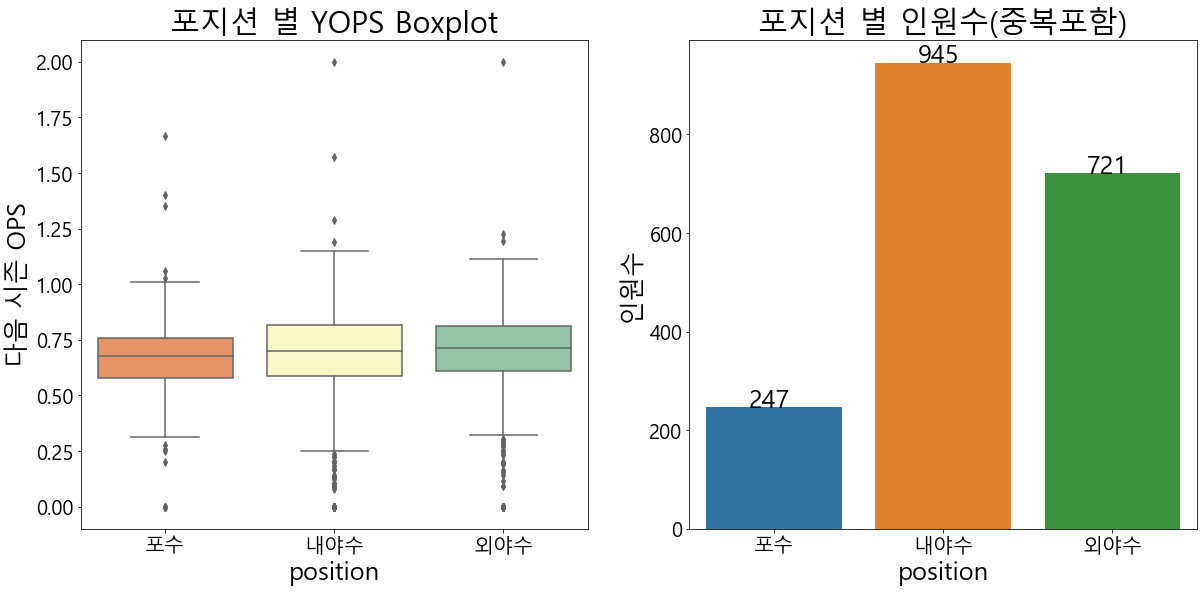

In [21]:
plt.figure(figsize=(20,9))

plt.subplot(121)
sns.boxplot(x='tp',y="YOPS", data=regular_y,palette="Spectral")
plt.title('포지션 별 YOPS Boxplot',size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('position',size=25)
plt.ylabel('다음 시즌 OPS',size=25)

fkd1= list(Counter(regular_y['tp']).keys())
fkd2= list(Counter(regular_y['tp']).values())
plt.subplot(122)
sns.barplot(x=fkd1,y=fkd2)
plt.title('포지션 별 인원수(중복포함)',size=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('position',size=25)
plt.ylabel('인원수',size=25)
for x,y in zip(range(0,len(fkd1)),fkd2):
    if len(str(y))==2:
        plt.text(x-0.05,y,fkd2[x],size=25)
    else:
        plt.text(x-0.15,y,fkd2[x],size=25)

In [22]:
del regular_y['cp']
del regular_y['year_born']
del regular_y['p_year']

## 2-3. 결측치 처리

In [23]:
regular_y[regular_y.isnull()['YOPS']]

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,hand2,tp,1B,FBP,avg,OBP,SLG,OPS,YAB,YOPS
188,전민재,19.0,12.0,8.0,8.0,2.0,3.0,1.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,2018,2700,0.047,우타,내야수,2.0,0.0,0.375,0.375,0.500,0.875,0.0,NaN
607,최윤석,30.0,21.0,33.0,32.0,3.0,7.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,2017,5200,-0.343,우타,내야수,7.0,0.0,0.219,0.219,0.219,0.438,0.0,NaN
691,양원혁,27.0,7.0,6.0,5.0,3.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2018,2900,0.096,좌타,내야수,2.0,1.0,0.400,0.500,0.400,0.900,0.0,NaN
715,양종민,22.0,2.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2012,3200,0.018,양타,내야수,1.0,0.0,0.250,0.250,0.250,0.500,0.0,NaN
878,이준수,25.0,47.0,74.0,65.0,6.0,13.0,3.0,0.0,0.0,16.0,6.0,0.0,0.0,3.0,3.0,0.0,21.0,0.0,2.0,1.0,2013,3400,-0.081,우타,포수,10.0,6.0,0.200,0.264,0.246,0.510,0.0,NaN
979,박계범,19.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015,2700,0.016,우타,내야수,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN
1042,지성준,21.0,9.0,12.0,12.0,1.0,3.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2015,2700,-0.059,우타,포수,2.0,0.0,0.250,0.250,0.333,0.583,0.0,NaN
1183,백승룡,30.0,33.0,62.0,52.0,3.0,12.0,1.0,0.0,0.0,13.0,3.0,3.0,0.0,6.0,3.0,0.0,20.0,0.0,1.0,0.0,2012,3000,0.253,우타,내야수,11.0,9.0,0.231,0.344,0.250,0.594,0.0,NaN
1316,황진수,23.0,28.0,20.0,18.0,2.0,2.0,1.0,0.0,0.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,9.0,1.0,1.0,0.0,2012,2400,-0.117,양타,내야수,1.0,1.0,0.111,0.158,0.167,0.325,0.0,NaN
1420,강동관,20.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2016,2700,-0.046,우타,포수,0.0,0.0,0.000,0.000,0.000,0.000,0.0,NaN


In [24]:
regular_y[regular_y['batter_name']=='최윤석']

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,hand2,tp,1B,FBP,avg,OBP,SLG,OPS,YAB,YOPS
603,최윤석,23.0,47.0,93.0,76.0,13.0,7.0,2.0,0.0,0.0,9.0,2.0,7.0,1.0,8.0,1.0,0.0,19.0,1.0,7.0,1.0,2010,2400,-0.777,우타,내야수,5.0,9.0,0.092,0.186,0.118,0.304,156.0,0.696
604,최윤석,24.0,82.0,209.0,156.0,21.0,38.0,4.0,1.0,1.0,47.0,9.0,4.0,4.0,32.0,7.0,0.0,38.0,2.0,14.0,0.0,2011,3200,1.066,우타,내야수,32.0,39.0,0.244,0.395,0.301,0.696,170.0,0.612
605,최윤석,25.0,109.0,213.0,170.0,17.0,39.0,1.0,0.0,1.0,43.0,15.0,6.0,5.0,33.0,2.0,0.0,36.0,4.0,7.0,1.0,2012,5000,0.763,우타,내야수,37.0,35.0,0.229,0.359,0.253,0.612,67.0,0.595
606,최윤석,29.0,11.0,17.0,16.0,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,2016,5700,-0.423,우타,내야수,2.0,1.0,0.125,0.176,0.125,0.301,32.0,0.438
607,최윤석,30.0,21.0,33.0,32.0,3.0,7.0,0.0,0.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,1.0,0.0,2017,5200,-0.343,우타,내야수,7.0,0.0,0.219,0.219,0.219,0.438,0.0,NaN
608,최윤석,31.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2018,4800,0.003,우타,내야수,0.0,2.0,NaN,1.000,NaN,NaN,12.0,0.650


In [25]:
regular_y[regular_y['batter_name']=='양종민']

,batter_name,age,G,PA,AB,R,H,2B,3B,HR,TB,RBI,SB,CS,BB,HBP,GB,SO,GDP,BU,fly,year,salary,war,hand2,tp,1B,FBP,avg,OBP,SLG,OPS,YAB,YOPS
712,양종민,19.0,6.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2009,2400,0.006,양타,내야수,0.0,0.0,0.000,0.000,0.000,0.000,9.0,0.422
713,양종민,20.0,7.0,10.0,9.0,0.0,1.0,1.0,0.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,2010,2400,-0.052,양타,내야수,0.0,1.0,0.111,0.200,0.222,0.422,55.0,0.573
714,양종민,21.0,58.0,64.0,55.0,11.0,13.0,2.0,0.0,0.0,15.0,5.0,0.0,3.0,5.0,0.0,0.0,21.0,1.0,4.0,0.0,2011,2500,-0.105,양타,내야수,11.0,5.0,0.236,0.300,0.273,0.573,4.0,0.500
715,양종민,22.0,2.0,4.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2012,3200,0.018,양타,내야수,1.0,0.0,0.250,0.250,0.250,0.500,0.0,NaN
716,양종민,23.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2013,2700,0.000,양타,내야수,0.0,0.0,NaN,NaN,NaN,NaN,4.0,0.000
717,양종민,24.0,5.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2014,2900,-0.077,양타,내야수,0.0,0.0,0.000,0.000,0.000,0.000,16.0,0.534
718,양종민,28.0,21.0,15.0,14.0,5.0,4.0,0.0,1.0,0.0,6.0,1.0,0.0,0.0,1.0,0.0,0.0,5.0,1.0,0.0,0.0,2018,2900,-0.031,양타,내야수,3.0,1.0,0.286,0.333,0.429,0.762,44.0,0.352


In [26]:
regular_y['YOPS']=regular_y['YOPS'].fillna(0.00000)

# 3. 핵심변수 파악

## 3-1. 전체 변수간 상관관계 및 목적변수와의 상관관계

In [27]:
cor=regular_y.corr()

regular_y2=regular_y.copy()
del regular_y2['BB']
del regular_y2['HBP']
del regular_y2['year']
del regular_y2['1B']
del regular_y2['YAB']
del regular_y2['PA']
del regular_y2['batter_name']
del regular_y2['hand2']
del regular_y2['tp']

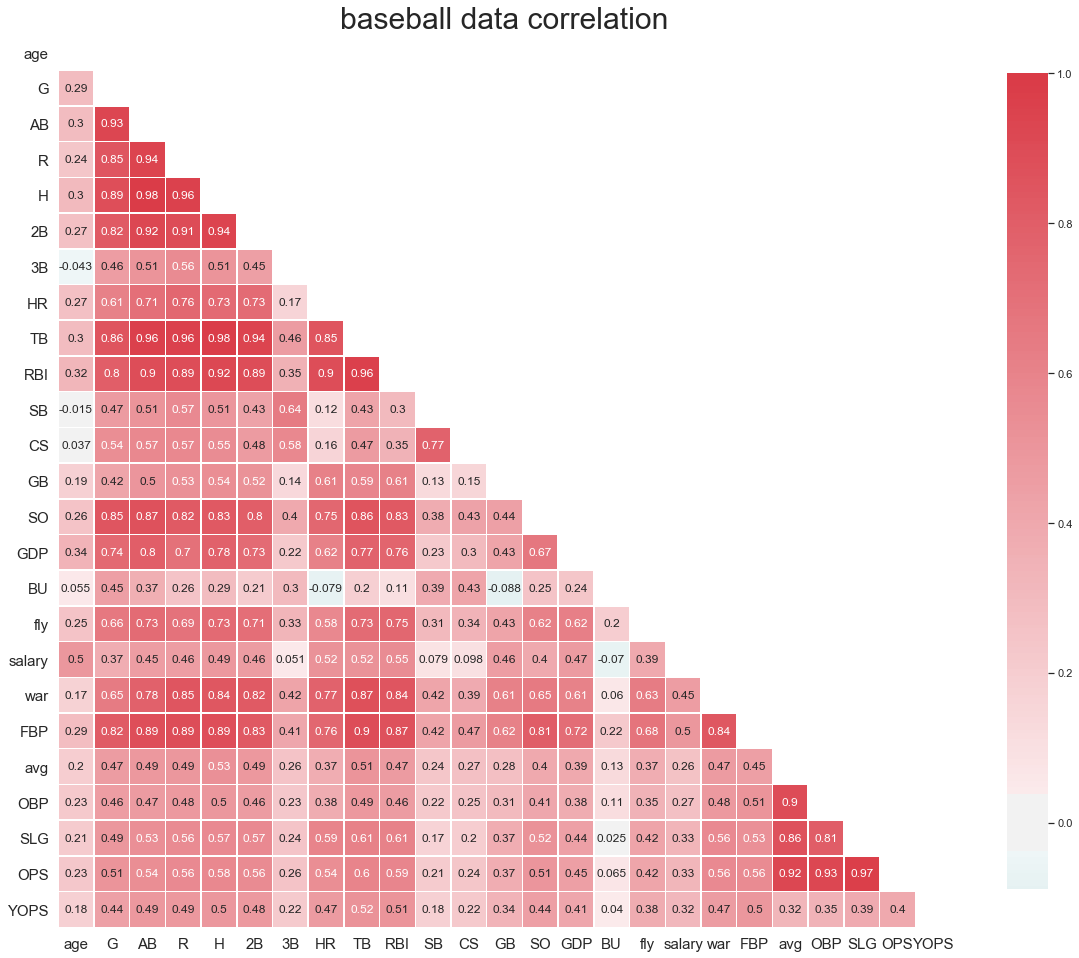

In [28]:
sns.set(style="white")

cor=regular_y2.corr()

mask=np.zeros_like(cor,dtype=np.bool)
mask[np.triu_indices_from(mask)]=True

f,ax=plt.subplots(figsize=(20,20))
cmap=sns.diverging_palette(200,10,as_cmap=True)
sns.heatmap(cor,mask=mask,cmap=cmap,center=0,square=True,linewidths=0.5,cbar_kws={"shrink":0.75},annot=True)
plt.title('baseball data correlation',size=30)
ax.set_xticklabels(list(regular_y2.columns),size=15)
ax.set_yticklabels(list(regular_y2.columns),size=15,rotation=0);

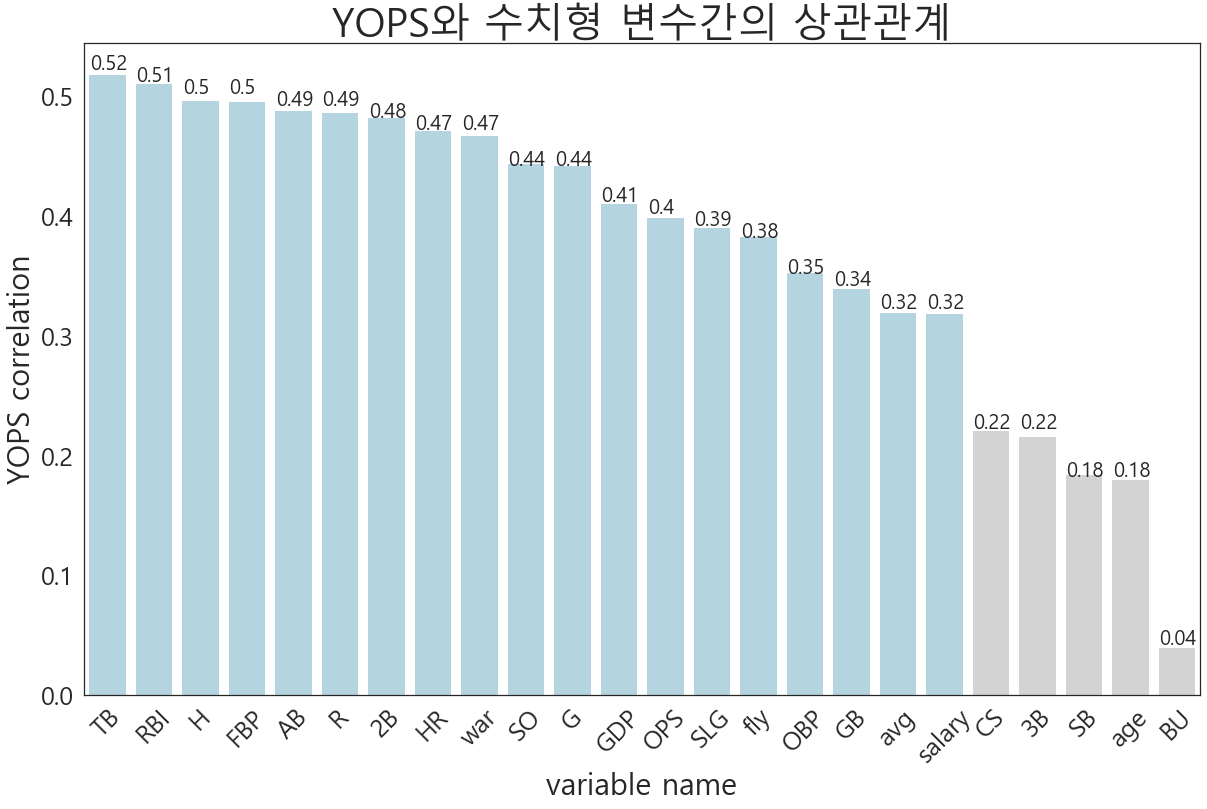

In [29]:
#글자 깨지는 부분 방지용도
if platform.system()=='Windows':
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font',family=font_name)
else:
    rc('font',family='AppleGothic')

cor=regular_y2.corr()

f,ax=plt.subplots(figsize=(20,12))
ax=sns.barplot(x=cor['YOPS'].sort_values(ascending=False)[1:].keys(), y=cor['YOPS'].sort_values(ascending=False)[1:].values,
            palette=['lightblue' if _y >0.3  else 'lightgrey' if (_y > (-0.1) and ( _y <= 0.3)) else 'lightcoral' for _y in list(cor['YOPS'].sort_values(ascending=False)[1:].values) ])
plt.xticks(fontsize=25,rotation=45)
plt.yticks(fontsize=25)
plt.xlabel('variable name',size=30)
plt.ylabel('YOPS correlation',size=30)
plt.title('YOPS와 수치형 변수간의 상관관계',size=40)

tk=[round(i,2) for i in cor['YOPS'].sort_values(ascending=False)[1:].values]
for x,y in zip(range(0,len(tk)),tk):
        plt.text(x-0.375,y+0.0025,tk[x],size=20);

## 3-2. 핵심 변수들 분포 및 상관관계

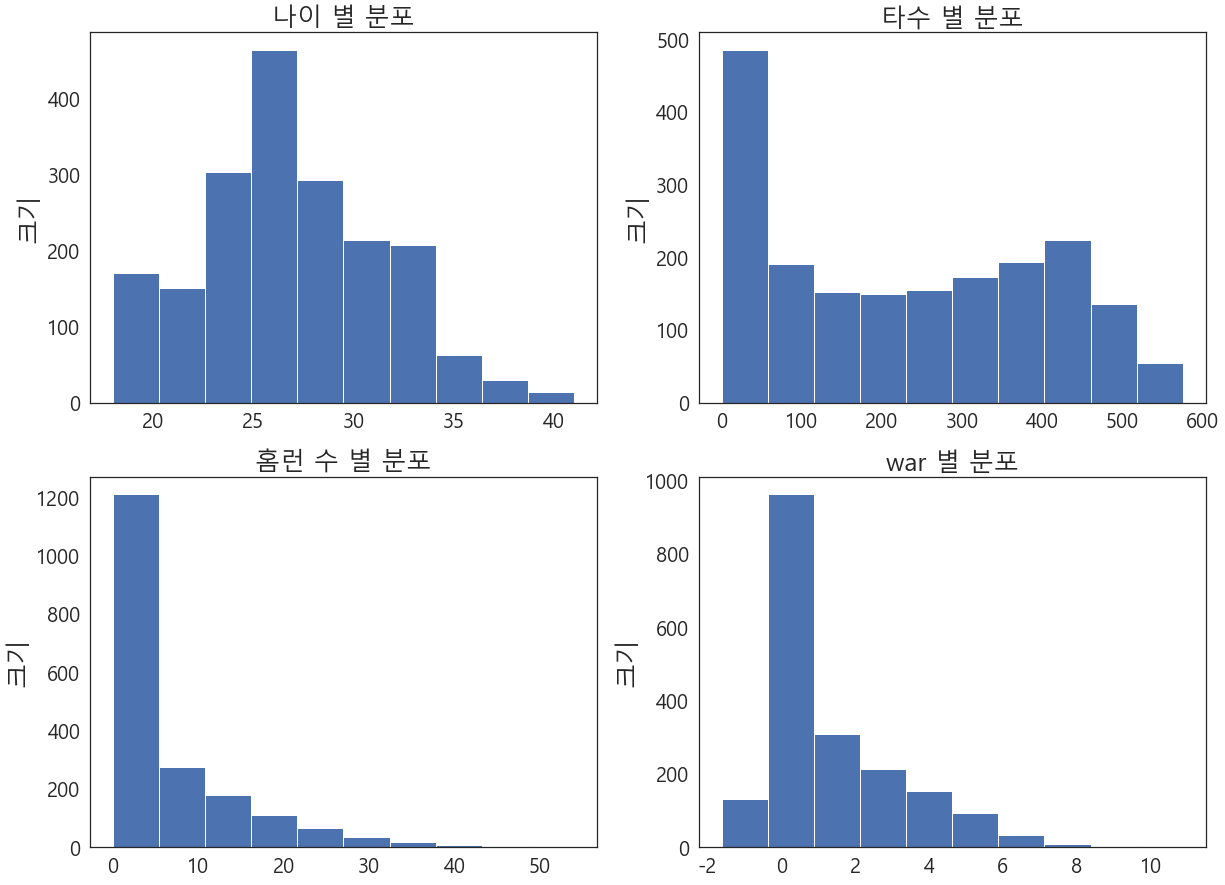

In [30]:
fig = plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
plt.hist(regular_y2['age'])
plt.title('나이 별 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('크기',size=25)

plt.subplot(2,2,2)
plt.hist(regular_y2['AB'])
plt.title('타수 별 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('크기',size=25)

plt.subplot(2,2,3)
plt.hist(regular_y2['HR'])
plt.title('홈런 수 별 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('크기',size=25)

plt.subplot(2,2,4)
plt.hist(regular_y2['war'])
plt.title('war 별 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('크기',size=25);

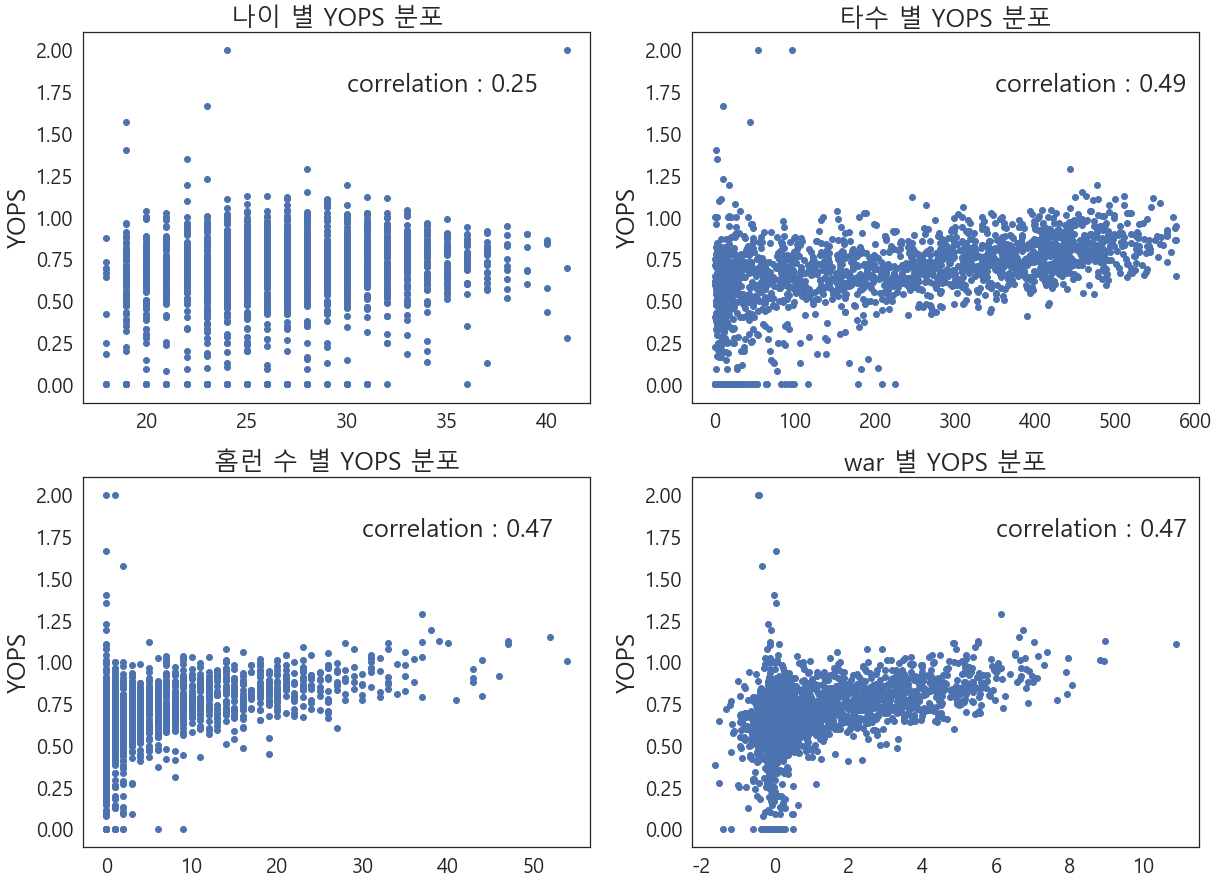

In [31]:
fig = plt.figure(figsize=(20,15))

plt.subplot(2,2,1)
plt.scatter(regular_y2['age'], regular_y2['YOPS'])
plt.title('나이 별 YOPS 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('YOPS',size=25)
plt.text(30,1.75,'correlation : 0.25',size=25)

plt.subplot(2,2,2)
plt.scatter(regular_y2['AB'], regular_y2['YOPS'])
plt.title('타수 별 YOPS 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('YOPS',size=25)
plt.text(350,1.75,'correlation : 0.49',size=25)

plt.subplot(2,2,3)
plt.scatter(regular_y2['HR'], regular_y2['YOPS'])
plt.title('홈런 수 별 YOPS 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('YOPS',size=25)
plt.text(30,1.75,'correlation : 0.47',size=25)

plt.subplot(2,2,4)
plt.scatter(regular_y2['war'], regular_y2['YOPS'])
plt.title('war 별 YOPS 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('YOPS',size=25)
plt.text(6,1.75,'correlation : 0.47',size=25);

# 4. 변수 추가

## 4-1. 추가 도루횟수, eqa~babip 만들기

In [32]:
#도루 횟수 관련 변수 만들기
regular_y['run']=regular_y['SB']+regular_y['CS']

# eqa 구하기
eqa_high=regular_y['H']+regular_y['TB']+1.5*(regular_y['FBP'])+regular_y['run']  #eqa 분자 공식
eqa_low=regular_y['AB']+regular_y['FBP']+regular_y['CS']+(regular_y['run']/3) #eqa 분모 공식
regular_y['eqa']=round(eqa_high/eqa_low,3) #분자/분모
regular_y['eqa']=regular_y['eqa'].fillna(0) # NaN을 0으로 처리

# isop 구하기
regular_y['avg']=regular_y['avg'].replace('-',0.0) #현재 avg중에서 -처리가 된 것이 있어 0으로 대체함
regular_y['SLG']=regular_y['SLG'].fillna(0) # NaN을 0으로 처리
    
coerce_df_columns_to_numeric(regular_y,'avg') #문자로 인식이 되는 문제가 있어 숫자로 변경

regular_y['isop']=regular_y['SLG']-regular_y['avg'] #공식 사용
regular_y['isop']=round(regular_y['isop'],3) #보기 편하기 위해 소수3자리로 반올림

# 운 변수 투입하기
#데이콘 측에서 사용한 행운 변수 추가해보기
regular_y['1b_luck']=regular_y['1B']/(regular_y['AB']-regular_y['HR']-regular_y['SO'])
regular_y['2b_luck']=regular_y['2B']/(regular_y['AB']-regular_y['HR']-regular_y['SO'])
regular_y['3b_luck']=regular_y['3B']/(regular_y['AB']-regular_y['HR']-regular_y['SO'])

#심화적인 변수들중 BB%,SO%가 쓰이는 경우가 있다.

regular_y['BB%']=regular_y['BB']/regular_y['PA']
regular_y['BB%']=regular_y['BB%'].fillna(0.0)
regular_y['BB%']=round(regular_y['BB%'],3)

regular_y['SO%']=regular_y['SO']/regular_y['PA']

#BABIP구하기
regular_y['babip']= round( (regular_y['H']-regular_y['HR']) / (regular_y['AB']-regular_y['SO']-regular_y['HR']+regular_y['fly']) ,3)
regular_y['babip']=regular_y['babip'].fillna(0) # NaN을 0으로 처리

## 4-3. 심화 변수들 생성

### SPD 구하기 

타자의 속도와 관련된 변수로 spd는 5개의 척도들의 평균을 이용한 값으로 

f1은 도루성공 관련, f2는 도루관련 f3은 홈런제외 타구비율
f4는 3루타 비율 f5는 병살관련 부분이다.

In [33]:
agg={}
for i in range(2006,2019,1):

    regular3=regular_y[ (regular_y['year']==i) & (regular_y['AB']>=100) ]
    regular3=regular3.reset_index(drop=True)

    #인원수를 동일하게 맞춰줘야 되기 때문에 f1 ~f5를 다시 생성하였음

    f1= DataFrame( [( ((regular3['SB'][i]+3) / (regular3['SB'][i]+regular3['CS'][i]+7)) -0.4) * 20 for i in range(len(regular3)) ] ,columns=['f1'])
    f2=DataFrame( [ (math.sqrt( (regular3['SB'][i]+regular3['CS'][i])/ ( (regular3['H'][i]-regular3['2B'][i]-regular3['3B'][i]-regular3['HR'][i]) +regular3['BB'][i]+regular3['HBP'][i]) )) /0.07 for i in range(len(regular3)) ] ,columns=['f2'])
    f3= DataFrame( [ (regular3['3B'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i]))*625 for i in range(len(regular3)) ] ,columns=['f3'])
    f4= DataFrame( [ (((regular3['R'][i]-regular3['HR'][i])/(regular3['H'][i]+regular3['BB'][i]-regular3['HR'][i]+regular3['HBP'][i]))-0.1)*25 for i in range(len(regular3)) ] ,columns=['f4'])
    f5= DataFrame( [ (0.063-(regular3['GDP'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i])))/0.007 for i in range(len(regular3)) ] ,columns=['f5'])

    f_total=pd.concat([f1,f2,f3,f4,f5],axis=1)

    scaler = MinMaxScaler()
    scaler.fit(f_total)

    f_total2=DataFrame(scaler.transform(f_total)*10)

    f_total3=pd.concat([regular3[['batter_name','year']],f_total2 ],axis=1)
    f_total3=f_total3.fillna(0) #비어있는 부분을 0으로 채움

    f_total3['spd'] = (f_total3[0]+f_total3[1]+f_total3[2]+f_total3[3]+f_total3[4])/5
    agg[i-2006]=f_total3[['batter_name','year','spd']]

In [34]:
regular3=regular_y[ (regular_y['year']<=2005) & (regular_y['AB']>=100) ]
regular3=regular3.reset_index(drop=True)

#인원수를 동일하게 맞춰줘야 되기 때문에 f1 ~f5를 다시 생성하였음

f1= DataFrame( [( ((regular3['SB'][i]+3) / (regular3['SB'][i]+regular3['CS'][i]+7)) -0.4) * 20 for i in range(len(regular3)) ] ,columns=['f1'])
f2=DataFrame( [ (math.sqrt( (regular3['SB'][i]+regular3['CS'][i])/ ( (regular3['H'][i]-regular3['2B'][i]-regular3['3B'][i]-regular3['HR'][i]) +regular3['BB'][i]+regular3['HBP'][i]) )) /0.07 for i in range(len(regular3)) ] ,columns=['f2'])
f3= DataFrame( [ (regular3['3B'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i]))*625 for i in range(len(regular3)) ] ,columns=['f3'])
f4= DataFrame( [ (((regular3['R'][i]-regular3['HR'][i])/(regular3['H'][i]+regular3['BB'][i]-regular3['HR'][i]+regular3['HBP'][i]))-0.1)*25 for i in range(len(regular3)) ] ,columns=['f4'])
f5= DataFrame( [ (0.063-(regular3['GDP'][i]/(regular3['AB'][i]-regular3['HR'][i]-regular3['SO'][i])))/0.007 for i in range(len(regular3)) ] ,columns=['f5'])

f_total=pd.concat([f1,f2,f3,f4,f5],axis=1)

scaler = MinMaxScaler()
scaler.fit(f_total)

f_total2=DataFrame(scaler.transform(f_total)*10)

f_total3=pd.concat([regular3[['batter_name','year']],f_total2 ],axis=1)
f_total3=f_total3.fillna(0) #비어있는 부분을 0으로 채움

f_total3['spd'] = (f_total3[0]+f_total3[1]+f_total3[2]+f_total3[3]+f_total3[4])/5
agg[13]=f_total3[['batter_name','year','spd']]

In [35]:
f_real=pd.concat(agg,ignore_index=True)
f_real=f_real.drop_duplicates(keep='first')

regular_y3=pd.merge(regular_y,f_real,how='left',on=['batter_name','year'])

# regular_y3.to_csv("regular3.csv",index=False)

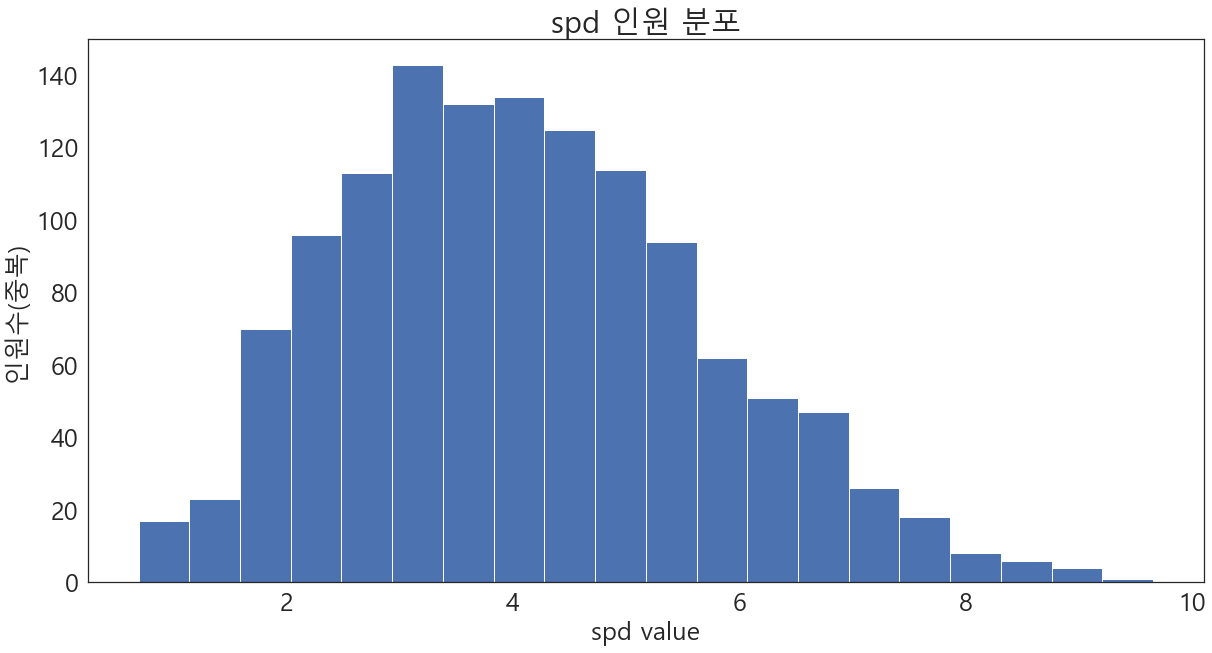

In [36]:
#변화되는 공식이 아닌 일반적인 공식을 사용하였음
regular_y3['spd'].hist(bins=20,figsize=(20,10)) #확인 필요
plt.grid(False)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('spd value',size=25)
plt.ylabel('인원수(중복) ',size=25)
plt.title('spd 인원 분포',size=30);

In [37]:
regular_y3['spd']=regular_y3['spd'].fillna(regular_y3['spd'].mean())

### wOBA구하기

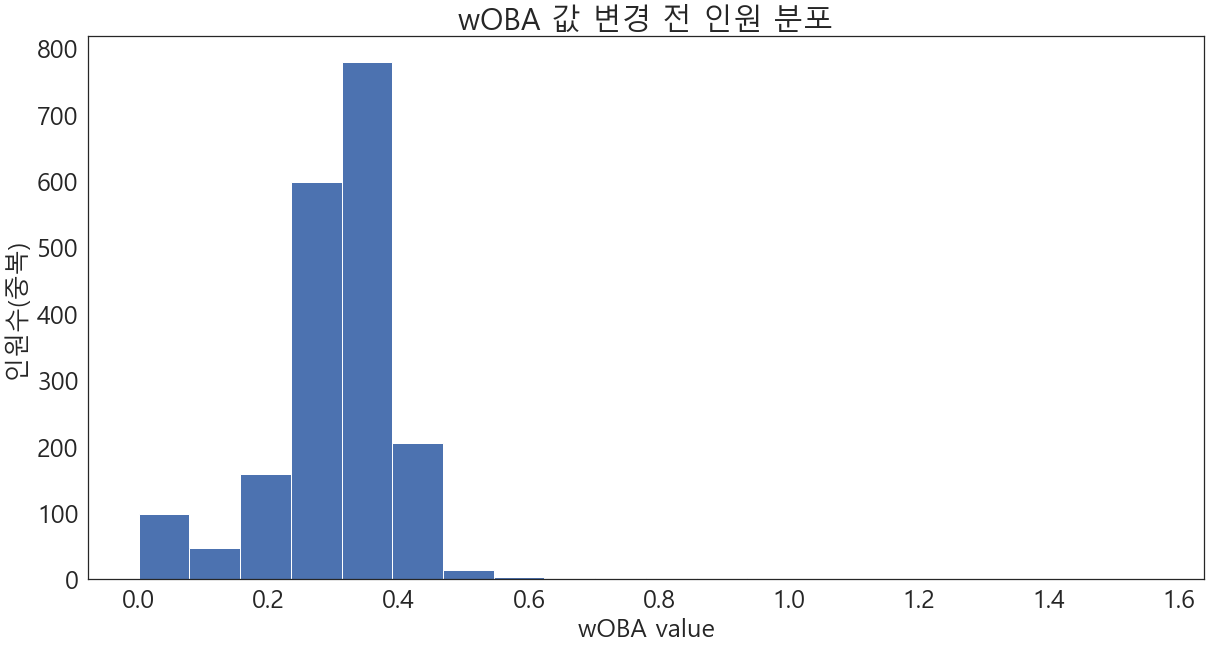

In [38]:
#변화되는 공식이 아닌 일반적인 공식을 사용하였음
regular_y3['wOBA']=(0.72*regular_y3['BB'] + 0.75*regular_y3['HBP'] + 0.9*regular_y3['1B'] + 1.24*regular_y3['2B'] + 1.56*regular_y3['3B'] + 1.95*regular_y3['HR'] ) / ( regular_y3['AB'] +regular_y3['FBP'] + regular_y3['fly'] )
regular_y3['wOBA']=regular_y3['wOBA'].fillna(0.0) 

regular_y3['wOBA']=round(regular_y3['wOBA'],3)

regular_y3['wOBA'].hist(bins=20,figsize=(20,10)) #확인 필요
plt.grid(False)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('wOBA value',size=25)
plt.ylabel('인원수(중복) ',size=25)
plt.title('wOBA 값 변경 전 인원 분포',size=30);

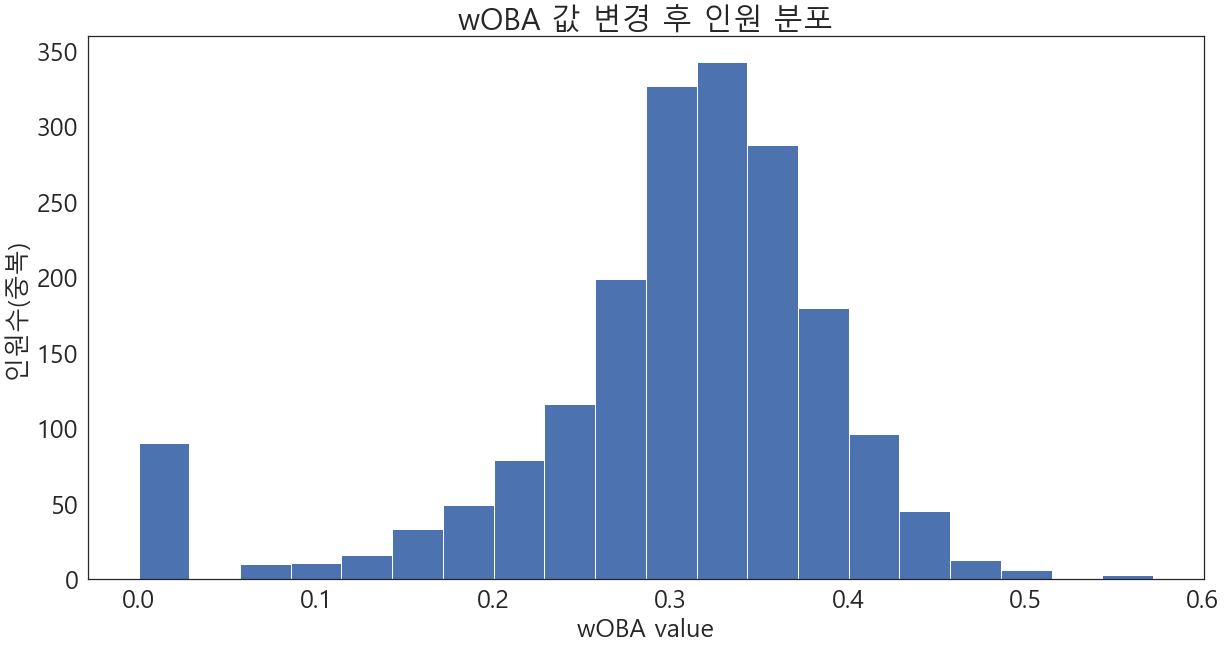

In [39]:
#변화되는 공식이 아닌 일반적인 공식을 사용하였음
regular_y3['wOBA']=(0.72*regular_y3['BB'] + 0.75*regular_y3['HBP'] + 0.9*regular_y3['1B'] + 1.24*regular_y3['2B'] + 1.56*regular_y3['3B'] + 1.95*regular_y3['HR'] ) / ( regular_y3['AB'] +regular_y3['FBP'] + regular_y3['fly'] )
regular_y3['wOBA']=regular_y3['wOBA'].fillna(0.0) 

regular_y3['wOBA']=round(regular_y3['wOBA'],3)
regular_y33=regular_y3.loc[regular_y3['wOBA']<0.6]

regular_y33['wOBA'].hist(bins=20,figsize=(20,10)) #확인 필요
plt.grid(False)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('wOBA value',size=25)
plt.ylabel('인원수(중복) ',size=25)
plt.title('wOBA 값 변경 후 인원 분포',size=30);

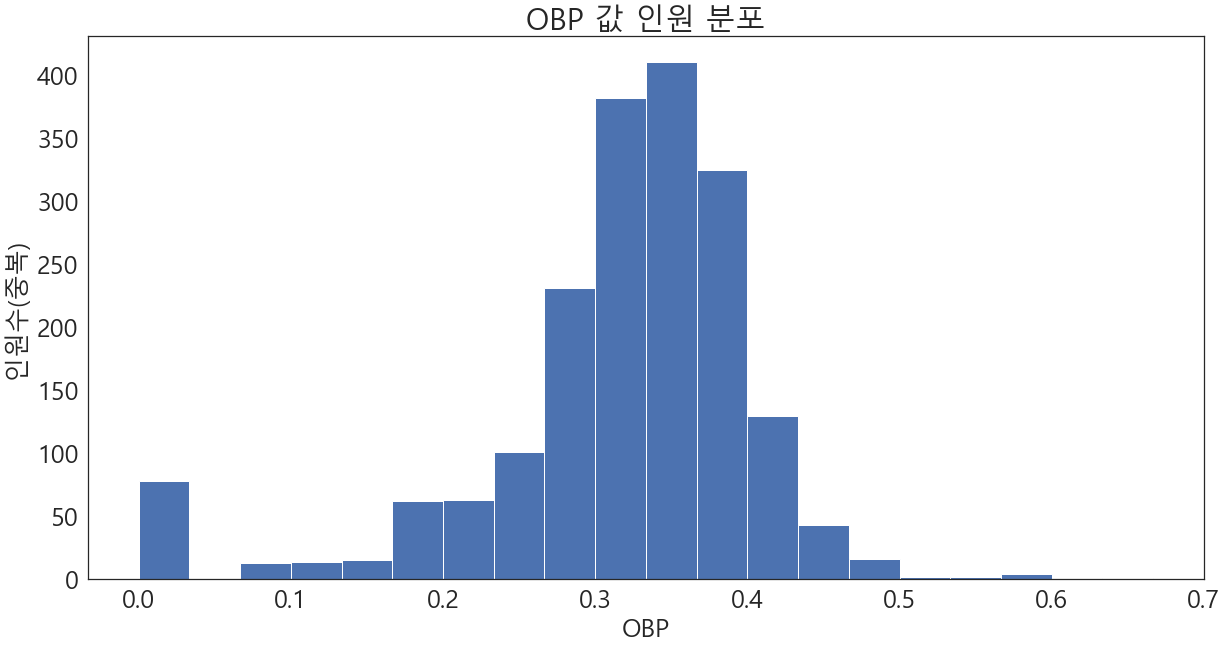

In [40]:
regular_y33['OBP'].hist(bins=20,figsize=(20,10)) #확인 필요
plt.grid(False)
plt.xticks(size=25)
plt.yticks(size=25)
plt.xlabel('OBP',size=25)
plt.ylabel('인원수(중복) ',size=25)
plt.title('OBP 값 인원 분포',size=30);

### OPS+구하기

In [41]:
#각 시즌별 평균 값이 필요하기 때문에 해당 과정을 실시
mra=regular_y3.groupby(['year'])['wOBA', 'R','H','FBP', 'AB', 'fly', 'TB'].sum()
mra2=regular_y3.groupby(['year'])['wOBA', 'R','H','FBP', 'AB', 'fly', 'TB'].size()
mra['size']=mra2

mra.to_csv("mra.csv")
mra=pd.read_csv("mra.csv")

In [42]:
# mra #현재 2000년대 연도들은 사이즈가 너무 작아서 평균을 구하는게 힘들어 보임
# #그래서 몇개 연도를 합쳐서 그 평균값을 사용하기로 결정함(2004년이전, 2005~2006 통합)

In [43]:
#2003년 이전 합치기
mra.loc[mra['year']<=2003,'wOBA']=(mra.loc[mra['year']<=2003,'wOBA'].sum()) 
mra.loc[mra['year']<=2003,'R']=(mra.loc[mra['year']<=2003,'R'].sum()) 
mra.loc[mra['year']<=2003,'H']=(mra.loc[mra['year']<=2003,'H'].sum()) 
mra.loc[mra['year']<=2003,'FBP']=(mra.loc[mra['year']<=2003,'FBP'].sum()) 
mra.loc[mra['year']<=2003,'AB']=(mra.loc[mra['year']<=2003,'AB'].sum()) 
mra.loc[mra['year']<=2003,'fly']=(mra.loc[mra['year']<=2003,'fly'].sum()) 
mra.loc[mra['year']<=2003,'TB']=(mra.loc[mra['year']<=2003,'TB'].sum()) 
mra.loc[mra['year']<=2003,'size']=(mra.loc[mra['year']<=2003,'size'].sum()) 

#2004년과 2005년 합치기

mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'wOBA']= (mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'wOBA'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'R']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'R'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'H']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'H'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'FBP']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'FBP'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'AB']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'AB'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'fly']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'fly'].sum())
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'TB']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'TB'].sum()) 
mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'size']=(mra.loc[(mra['year']<=2005) & (mra['year']>=2004) ,'size'].sum()) 

#2006 2007
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'wOBA']= (mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'wOBA'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'R']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'R'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'H']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'H'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'FBP']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'FBP'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'AB']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'AB'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'fly']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'fly'].sum())
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'TB']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'TB'].sum()) 
mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'size']=(mra.loc[(mra['year']<=2007) & (mra['year']>=2006) ,'size'].sum()) 

#2008 2009
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'wOBA']= (mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'wOBA'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'R']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'R'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'H']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'H'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'FBP']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'FBP'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'AB']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'AB'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'fly']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'fly'].sum())
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'TB']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'TB'].sum()) 
mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'size']=(mra.loc[(mra['year']<=2009) & (mra['year']>=2008) ,'size'].sum()) 

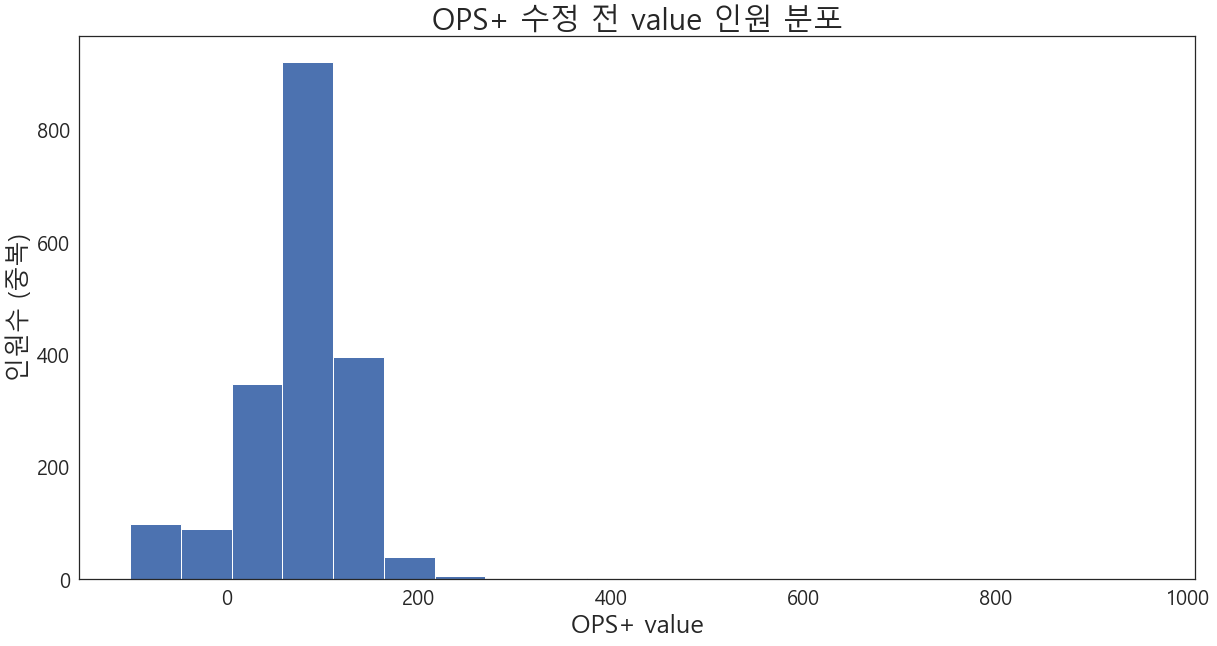

In [44]:
mra['aOBP']=(mra['H']+mra['FBP'])/(mra['AB']+mra['FBP']+mra['fly']) #각 연도의 평균 OBP생성

mra['aSLG']=mra['TB']/mra['AB'] #각 연도의 평균 SLG생성

mra_total=mra[['year','aOBP','aSLG']] #각 연도별 평균 OBP,SLG만 추출

regular4=pd.merge(regular_y3,mra_total,how='left') #각 선수별 OPS+를 적용시키기 위해서 통합 실시

#OPS + 를 구하는 공식을 사용하고 OPS+는 자연수 값이기 때문에 반올림로 정수 처리하였음
regular4['OPS+']= ( (regular4['OBP']/regular4['aOBP']) + (regular4['SLG']/regular4['aSLG']) -1 ) * 100
regular4['OPS+']=round(regular4['OPS+'],0)

regular4['OPS+'].hist(bins=20,figsize=(20,10)) #현재 0이하의 값과 200이상의 이상치들이 보이는 모습이 있음
plt.grid(False)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('OPS+ value',size=25)
plt.ylabel('인원수 (중복)',size=25)
plt.title('OPS+ 수정 전 value 인원 분포',size=30);

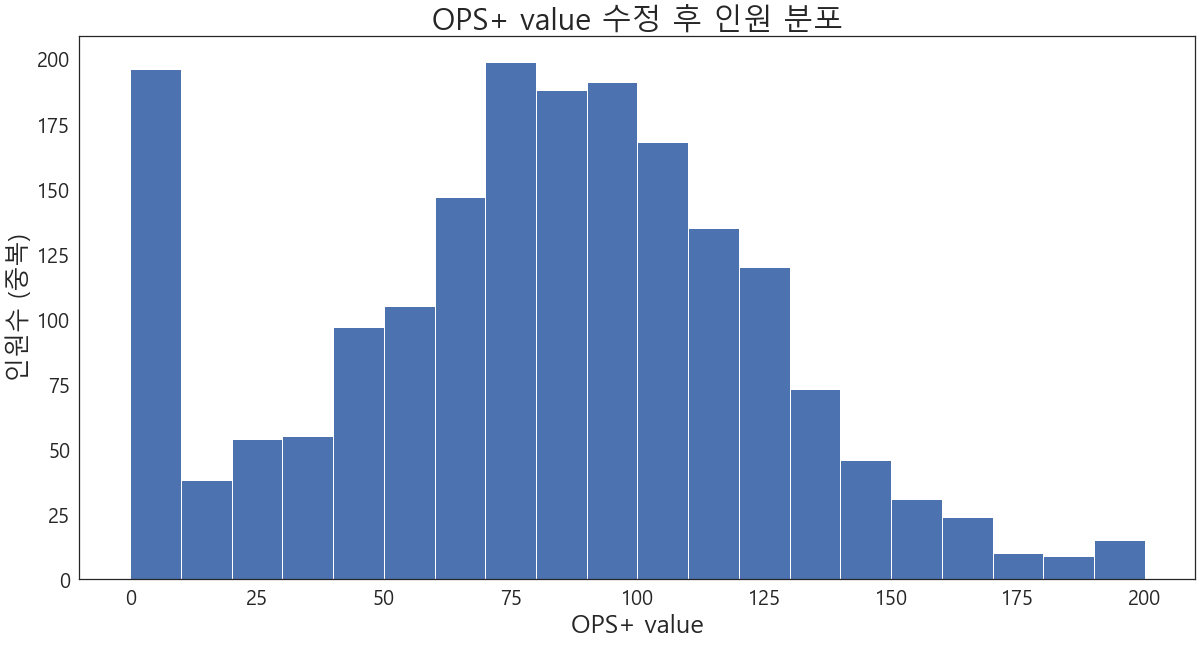

In [45]:
regular4.loc[regular4['OPS+']>=200,['OPS+']]=200 #200이상의 이상치는 200으로 처리
regular4.loc[regular4['OPS+']<=0,['OPS+']]=0 #0이하의 값은 0으로 처리

#다 사용이 된 평균 OBP,SLG는 삭제함
del regular4['aOBP']
del regular4['aSLG']

regular4['OPS+'].hist(bins=20,figsize=(20,10)) #이상치 제거 이후 OPS+확인 작업
plt.grid(False)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('OPS+ value',size=25)
plt.ylabel('인원수 (중복)',size=25)
plt.title('OPS+ value 수정 후 인원 분포',size=30);

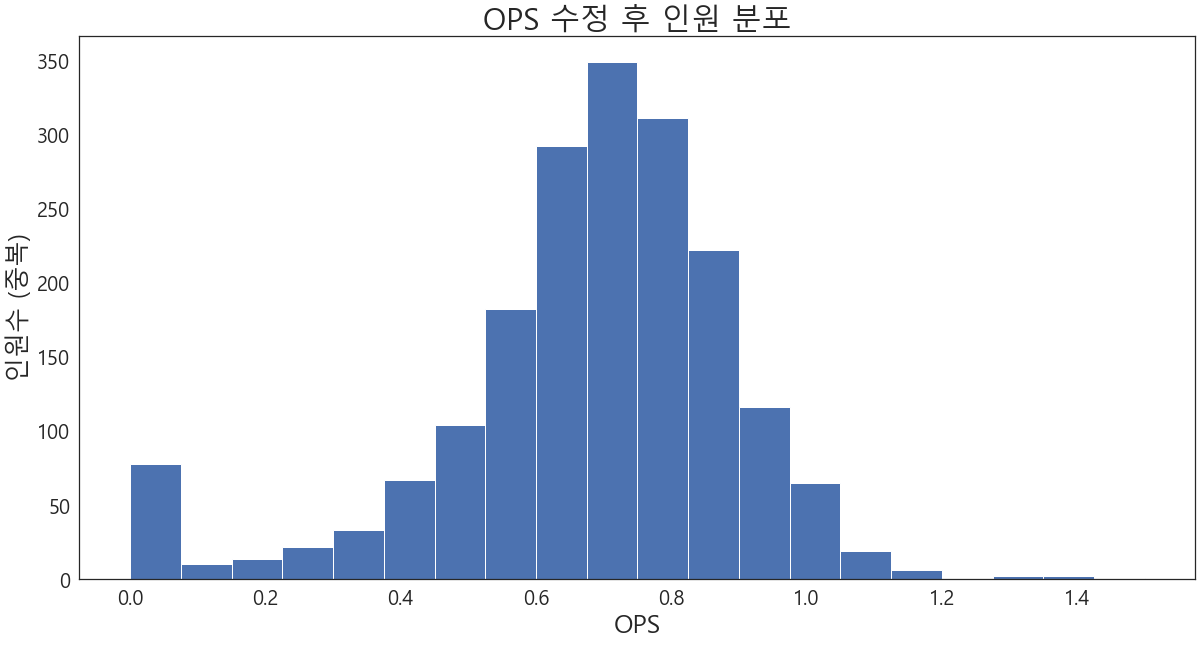

In [46]:
regular555=regular4[regular4['OPS']<=1.5]
regular555['OPS'].hist(bins=20,figsize=(20,10)) #이상치 제거 이후 OPS+확인 작업
plt.grid(False)
plt.xticks(size=20)
plt.yticks(size=20)
plt.xlabel('OPS',size=25)
plt.ylabel('인원수 (중복)',size=25)
plt.title('OPS 수정 후 인원 분포',size=30);

## 4-2. 선수당 시즌 보낸 횟수

In [47]:
regular46=regular4.copy()
regular46=regular46.sort_values(by=['batter_name', 'year']) #이름과 연도 별로 sort

tk=[i for i in regular46['batter_name'][1:]] #각 관측치마다 연차를 부여하기 위해서 생성
tk2=[i for i in regular46['batter_name'][0:]]

co=list() #해당 관측치와 다음 관측치의 이름이 같으면 1년차 -> 2년차의 방식을 빠르게 수행하기 위해서 시행
co.append(1)
for i in range(len(tk)):
    if tk[i]==tk2[i]:
        co.append(co[i]+1)
    else:
        co.append(1)
regular46['work_year']=co

regular46=regular46.sort_index()

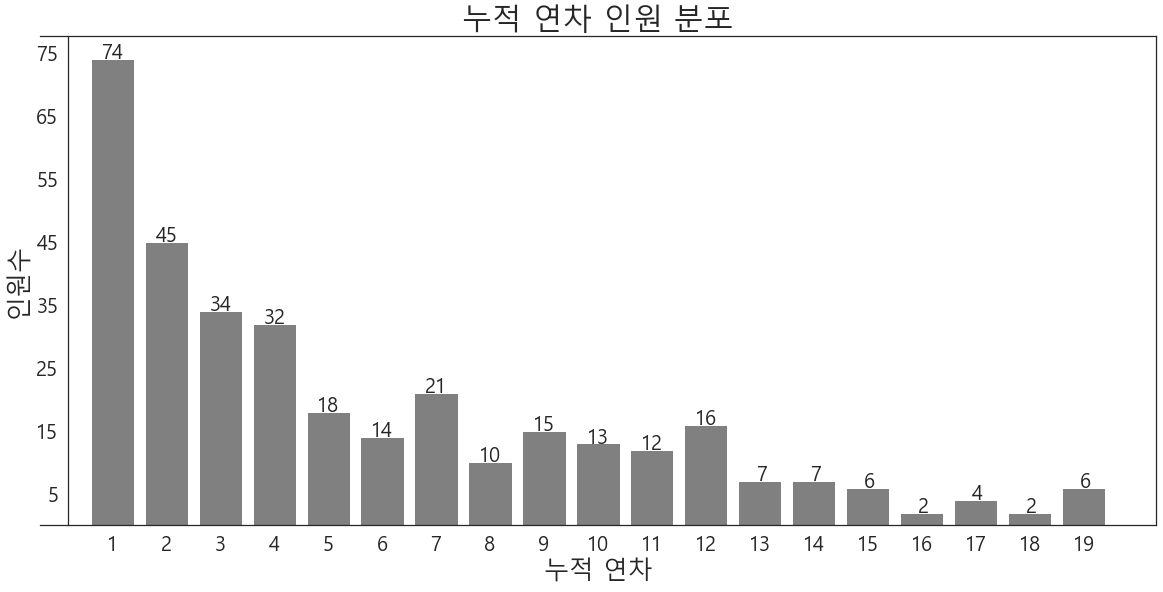

In [48]:
regular6=regular46[['batter_name','work_year']]

regular6=regular6.drop_duplicates(keep='first')

c=Counter(Counter(regular6['batter_name']).values()) #이름 갯수로 누적 시즌 횟수 획득
x3=[]
y3=[]
for i in range(len(c)):
    x3.append(sorted(c.items(), key=itemgetter(0))[i][0]) # 1~ 17
    y3.append(sorted(c.items(), key=itemgetter(0))[i][1]) # 해당 시즌 보낸 사람 인원수

f,ax=plt.subplots(figsize=(20,9))

plt.bar(x3,y3,color='grey')
plt.xticks(x3, (list(range(1,20))))
plt.yticks(range(5,80,10))
plt.xlabel('누적 연차',size=25)
plt.ylabel('인원수',size=25)
ax.spines['left'].set_position(('axes', 0.025))
plt.title('누적 연차 인원 분포',size=30)

#ax.spines를 한 이후 축 글자 크기 변경시 사용한 부분
for label in ax.get_xticklabels() + ax.get_yticklabels(): 
    label.set_fontsize(20)
    label.set_bbox(dict(facecolor='white', edgecolor='None', alpha=0.65 ))
    
for x,y in zip(range(1,20),y3):
    if y>=10:
        plt.text(x-0.2,y,y3[x-1],size=20)
    else:
        plt.text(x-0.075,y,y3[x-1],size=20)
        
regular46.to_csv("regular_total.csv",index=False)

### 공 반발계수 추가하기

In [51]:
# total=pd.read_csv("regular_total.csv")
total=regular46.copy()
total['ball_score']=0.45032

total['ball_score'] = [np.where( total['year'][i]==2009, np.random.normal(0.4297, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2010, np.random.normal(0.4187, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2011, np.random.normal(0.4228, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2012, np.random.normal(0.4172, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2013, np.random.normal(0.4236, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2014, np.random.normal(0.4316, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2015, np.random.normal(0.4244, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2016, np.random.normal(0.4216, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2017, np.random.normal(0.4224, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]
total['ball_score'] = [np.where( total['year'][i]==2018, np.random.normal(0.4187, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]

total['ball_score'] = [np.where( (total['year'][i]<2009) | (total['year'][i]>2018) , np.random.normal(0.42307, 0.005, 1)[0],total['ball_score'][i] ) for i in range(len(total))  ]

In [52]:
total['p_year']=total['year']+1
total['next_ball_score']=0.45032

total['next_ball_score'] = [np.where( total['p_year'][i]<2009, np.random.normal(0.42307, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2009, np.random.normal(0.4297, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2010, np.random.normal(0.4187, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2011, np.random.normal(0.4228, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2012, np.random.normal(0.4172, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2013, np.random.normal(0.4236, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2014, np.random.normal(0.4316, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2015, np.random.normal(0.4244, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2016, np.random.normal(0.4216, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2017, np.random.normal(0.4224, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2018, np.random.normal(0.4187, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]
total['next_ball_score'] = [np.where( total['p_year'][i]==2019, np.random.normal(0.41, 0.005, 1)[0],total['next_ball_score'][i] ) for i in range(len(total))  ]

In [53]:
coerce_df_columns_to_numeric(total,'ball_score') #문자로 입력된 것을 숫자로 변경

coerce_df_columns_to_numeric(total,'next_ball_score') #문자로 입력된 것을 숫자로 변경

cor1=total[['ball_score','next_ball_score','YOPS']].corr()

cor1

,ball_score,next_ball_score,YOPS
ball_score,1.000000,0.118942,0.038779
next_ball_score,0.118942,1.000000,0.057560
YOPS,0.038779,0.057560,1.000000


In [85]:
cor1['ball_score']['YOPS']

0.03877871505850206

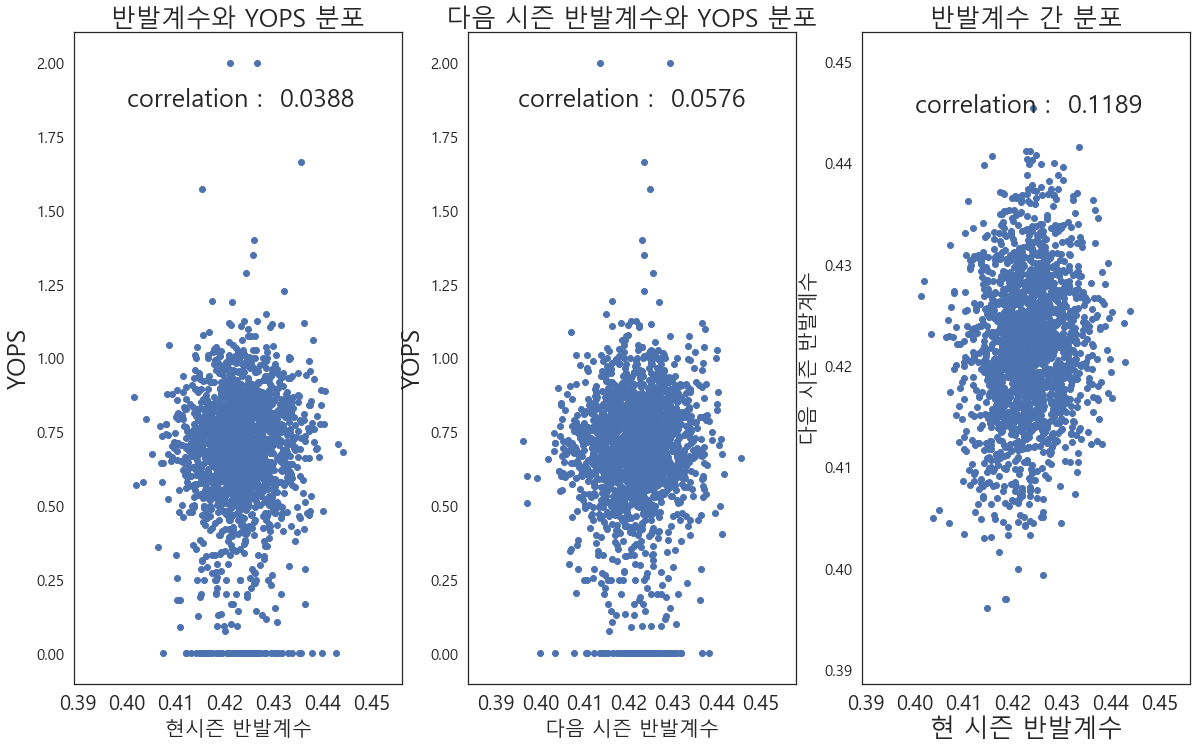

In [91]:
fig = plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
plt.scatter(total['ball_score'], total['YOPS'])
plt.title('반발계수와 YOPS 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('현시즌 반발계수',size=20)
plt.ylabel('YOPS',size=25)
plt.text(0.40,1.85, 'correlation :  ' + str(round(cor1['ball_score']['YOPS'],4)) ,size=25)

plt.subplot(1,3,2)
plt.scatter(total['next_ball_score'], total['YOPS'])
plt.title('다음 시즌 반발계수와 YOPS 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('다음 시즌 반발계수',size=20)
plt.ylabel('YOPS',size=25)
plt.text(0.395,1.85,'correlation :  ' + str(round(cor1['next_ball_score']['YOPS'],4)),size=25)

plt.subplot(1,3,3)
plt.scatter(total['ball_score'], total['next_ball_score'])
plt.title('반발계수 간 분포',size=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.xlabel('현 시즌 반발계수',size=25)
plt.ylabel('다음 시즌 반발계수',size=20)
plt.text(0.40,0.445, 'correlation :  ' + str(round(cor1['ball_score']['next_ball_score'],4)) ,size=25);

# total.to_csv("real_total.csv",index=False)

# 5. 모델링

## 5-1. train, test 나누기 및 변수 선택

In [55]:
# total=pd.read_csv("real_total.csv")

# total.head()

del total['BB']
del total['HBP']

del total['PA']

del total['SB']
del total['CS']

del total['OBP']
del total['SLG']

del total['1B']
del total['2B']
del total['3B']

del total['SO']

In [56]:
train=total.copy()
del train['p_year']

train_y2=train[['year','YAB','YOPS']]

y_train=train_y2[train_y2['year']<=2017].reset_index(drop=True)
y_test=train_y2[train_y2['year']==2018].reset_index(drop=True)

del y_train['year']
del y_test['year']

del train['batter_name']
del train['YAB']
del train['YOPS']

train = pd.get_dummies(train,columns=['hand2'])
train = pd.get_dummies(train,columns=['tp'])

X_train=train[train['year']<=2017].reset_index(drop=True)

X_test=train[train['year']==2018].reset_index(drop=True)

del X_train['year']
del X_test['year']

In [57]:
X_train=X_train.fillna(0.0000)

X_test=X_test.fillna(0.0000)

y_train=y_train.fillna(0.0000)

y_test=y_test.fillna(0.0000)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1718, 38), (195, 38), (1718, 2), (195, 2))

eda 제거

In [58]:
list1=list(X_train[X_train['OPS']>=1.25].index)
X_train=X_train.drop(list1,axis=0).reset_index(drop=True)
y_train=y_train.drop(list1,axis=0).reset_index(drop=True)

list2=list(X_train[X_train['OPS+']<=25].index)
X_train=X_train.drop(list2,axis=0).reset_index(drop=True)
y_train=y_train.drop(list2,axis=0).reset_index(drop=True)

# list3=list(X_train[ (X_train['AB']<=10) & (X_train['OPS']>=1) ].index)
# X_train=X_train.drop(list3,axis=0).reset_index(drop=True)
# y_train=y_train.drop(list3,axis=0).reset_index(drop=True)

# list4=list(X_train[ (X_train['AB']<=10) & (X_train['OPS']<=0.00001) ].index)
# X_train=X_train.drop(list4,axis=0).reset_index(drop=True)
# y_train=y_train.drop(list4,axis=0).reset_index(drop=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1460, 38), (195, 38), (1460, 2), (195, 2))

## 5-2. randomforestregressor

In [59]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2, 3],
    'min_samples_leaf': [7,9,11],
    'min_samples_split': [2,3],
    'n_estimators': [200,300,500]
}
# Create a based model
rf = RandomForestRegressor(criterion='mae',random_state=1234)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid)

grid_search.fit(X_train, y_train['YOPS'])

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mae',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=1234,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_features': [2, 3], 'm

In [60]:
grid_search.best_params_

{'max_features': 3,
 'min_samples_leaf': 7,
 'min_samples_split': 2,
 'n_estimators': 500}

In [61]:
best_grid = grid_search.best_estimator_

train 결측치 제거 추가적인 eda도 한 경우

In [107]:
y_pred_train = best_grid.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

train randomforest regressor mae : 0.0891


In [121]:
y_pred = best_grid.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

test randomforest regressor mae : 0.1235


In [122]:
print( 'test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

test randomforest regressor 가중치 rmse : 0.1039


In [123]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round( mean_absolute_error(df1['YOPS'], df1['predict']),4) )

50타수 이상 test randomforest regressor mae : 0.0903


In [124]:
print( '50타수 이상 test randomforest regressor 가중치 rmse :' , round( sqrt( (( (((df1['YOPS']-df1['predict'])**2)*df1['YAB']).sum() )  /  df1['YAB'].sum()) ),4) )

test randomforest regressor 가중치 rmse : 0.1008


## 5-3. xgbregressor, lin_reg 비교

In [68]:
est=XGBRegressor(max_depth=3, learning_rate=0.005, n_estimators=100,
                     objective='reg:linear', booster='gblinear', reg_lambda=1,
                     scale_pos_weight=190, base_score=0.4, random_state=0,
                     seed=None, missing=None)

result=est.fit(X_train, y_train['YOPS'], sample_weight=None, eval_set=None, eval_metric=None,
                  early_stopping_rounds=None, verbose=True, xgb_model=None)



[22:32:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [111]:
y_pred_train = result.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

train randomforest regressor mae : 0.1151


In [112]:
y_pred = result.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

test randomforest regressor mae : 0.1395


In [113]:
print( 'test randomforest regressor 가중치 rmse :' ,round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

test randomforest regressor 가중치 rmse : 0.128


In [114]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round(mean_absolute_error(df1['YOPS'], df1['predict']),4) )

50타수 이상 test randomforest regressor mae : 0.1089


linear regression

In [115]:
model2 = LinearRegression().fit(X_train, y_train['YOPS'])

y_pred_train = model2.predict(X_train)

print( 'train randomforest regressor mae :' , round(mean_absolute_error(y_train['YOPS'], y_pred_train),4) )

train randomforest regressor mae : 0.1075


In [116]:
y_pred = model2.predict(X_test)

print( 'test randomforest regressor mae :' , round(mean_absolute_error(y_test['YOPS'], y_pred),4) )

test randomforest regressor mae : 0.1371


In [117]:
print( 'test randomforest regressor 가중치 rmse :' ,round( sqrt( (( (((y_test['YOPS']-y_pred)**2)*y_test['YAB']).sum() )  /  y_test['YAB'].sum()) ),4) )

test randomforest regressor 가중치 rmse : 0.13


In [118]:
df1 = DataFrame( list(zip(y_test['YOPS'],y_pred,y_test['YAB'])), columns=['YOPS','predict','YAB']  )

df1 = df1[df1['YAB']>=50]

print( '50타수 이상 test randomforest regressor mae :' , round(mean_absolute_error(df1['YOPS'], df1['predict']),4) )

50타수 이상 test randomforest regressor mae : 0.1054


# 6. 최종 결론

In [77]:
n_feature = X_train.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)
input_var=X_train.columns

학습된 rf에서 feature_importance_를 입력하면, 해당 변수에 대한 변수 중요도가 수치적으로 나타난다.

이를 수평 막대 그래프를 활용하여 그리는 과정은 다음과 같다.

In [78]:
from matplotlib import font_manager, rc #그래프 폰트 깨질경우 방지 부분

#폰트 깨지는거 수정 부분
import platform
if platform.system()=='Windows':
    font_name=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font',family=font_name)
else:
    rc('font',family='AppleGothic')

In [79]:
score2=DataFrame( list(zip(input_var,best_grid.feature_importances_  )), columns=['name','importance'])
score2=score2.sort_values('importance')
score3=score2.sort_values('importance',ascending=False)

In [80]:
score3.head(6)

,name,importance
6,TB,0.064923
27,wOBA,0.060854
7,RBI,0.059516
5,HR,0.054989
19,isop,0.054869
16,OPS,0.054335


In [81]:
score3.tail(6)

,name,importance
34,hand2_좌타,0.003658
33,hand2_우타,0.003209
36,tp_외야수,0.003156
35,tp_내야수,0.002590
37,tp_포수,0.002241
32,hand2_양타,0.000058


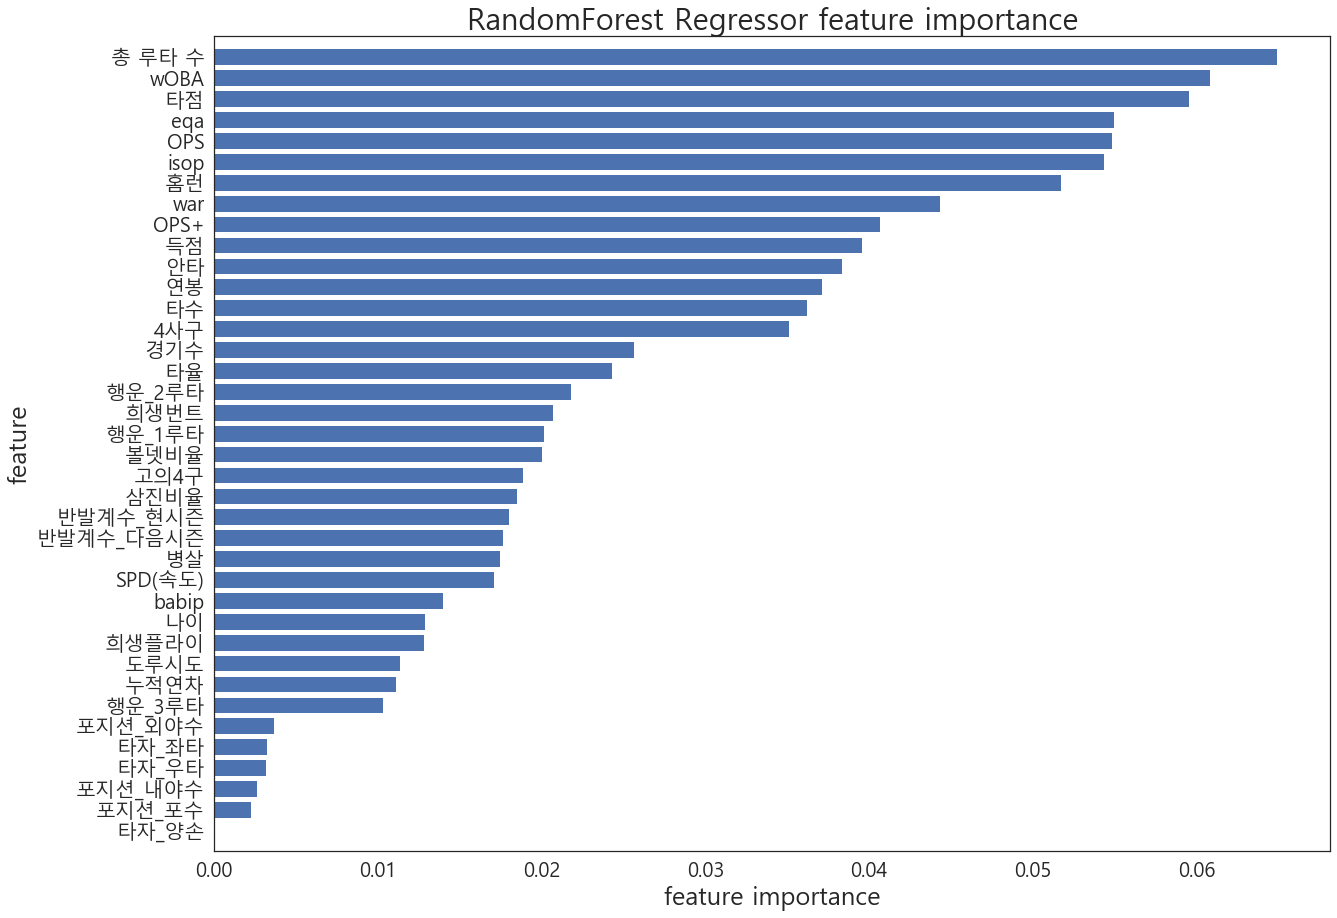

In [82]:
list2=["타자_양손","포지션_포수","포지션_내야수","타자_우타","타자_좌타","포지션_외야수","행운_3루타","누적연차",
       "도루시도","희생플라이","나이","babip","SPD(속도)","병살","반발계수_다음시즌","반발계수_현시즌","삼진비율",
       "고의4구","볼넷비율","행운_1루타","희생번트","행운_2루타","타율","경기수","4사구","타수","연봉","안타","득점",
       "OPS+","war","홈런","isop","OPS","eqa","타점","wOBA","총 루타 수"]

score2['name']=score2['name'].replace(list(score2['name']),list2)

plt.rcParams["figure.figsize"] = (20,15)

plt.barh(index, score2['importance'], align='center') #
plt.xticks(size=20)
plt.yticks(index, score2['name'],size=20)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=25)
plt.ylabel('feature', size=25)
plt.title('RandomForest Regressor feature importance', size=30)
plt.show();